In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, find_peaks, peak_prominences
from typing import Tuple

from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [26]:
peak_height = 0.25
CHROM_SETTINGS = {
    'fr': 30,  # frame rate
    'freq': (0.5, 2.5),  # bandpass frequency range
    'bandpass_order': 4,  # bandpass filter order
    'moving_avg_window': 6,  # moving average window size for smoothing
    'peak_height': peak_height,  # min peak height for peak detection
    'slice_filter_thresh': 2,  # min number of peaks allowed in a slice of the signal
    'stringent_perc': 85,  # more stringent percentile for peak filtering
    'non_stringent_perc': 75,  # less stringent percentile for peak filtering
}

In [27]:
def bandpass(signal: np.ndarray, fr: int, freq: Tuple[float, float], order: int):
    """
    Apply bandpass filter to the given signal.

    fr - frame rate
    freq - tuple of low and high frequencies for the bandpass filter
    order - order of the bandpass filter
    """

    # nyquist frequency stays hardcoded at half the frame rate
    nyquist_freq = 0.5 * fr
    
    # low and high values for butter created using nyquist
    low = freq[0] / nyquist_freq
    high = freq[1] / nyquist_freq
    
    # apply the filter
    b, a = butter(order, [low, high], btype = 'band')
    filtered = filtfilt(b, a, signal)
    return filtered

def detrend_w_poly(signal: np.ndarray, degree: int = 3):
    """
    Detrend signal using nth degree polynomial.
    """

    siglen = len(signal)
    x = np.arange(siglen)
    poly = np.polyfit(x, signal, degree)
    curve = np.poly1d(poly)(x)
    return signal - curve

def normalize_signal(signal: np.ndarray):
    """
    Normalize the given signal using mean and std.
    """

    mn = np.mean(signal)
    std = np.std(signal)
    return (signal - mn) / std

def n_moving_avg(signal: np.ndarray, window: int = 5):
    """
    Simple moving window smoothing for a given signal.
    """

    result = []
    for i in range(len(signal) - (window - 1)):
        result.append(
            float(sum(signal[i: i + window])) / window
        )
    
    return np.array(result)

def normalize_amplitude_to_1(signal: np.ndarray):
    """
    Normalize amplitude of given signal to 1.
    """
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    
    first_part = list(signal[0: first_index])
    signal = signal[first_index: ]

    sigmax = abs(max(signal))
    sigmin = abs(min(signal))
    
    return np.array(first_part + [
        v / sigmax if v > 0 else v / sigmin
        for v in signal
    ])

BVP1 Length: 1280
RGB1 Length: 600
BVP2 Length: 1280
RGB2 Length: 600
Length Ratio 1: 2.13
Length Ratio 2: 2.13


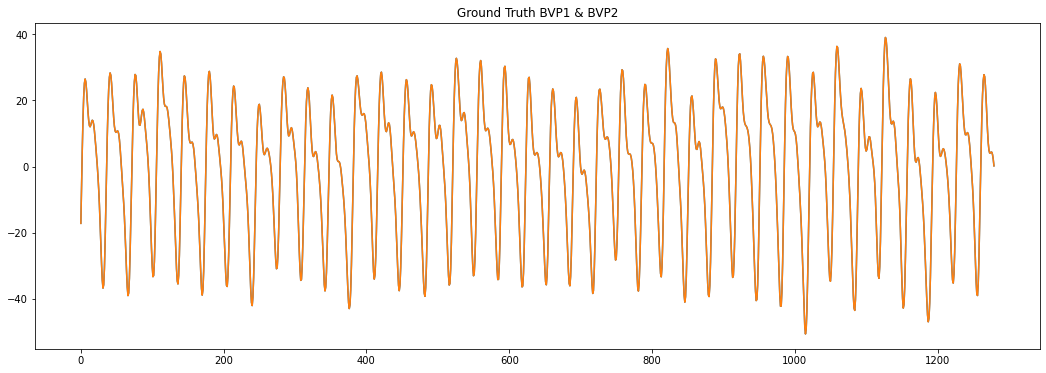

In [28]:
truth1 = IeeeGroundTruth(5, 1)
truth1.align_rgb_bvp()
truth2 = IeeeGroundTruth(5, 1, directory = 'channel_data3')
truth2.align_rgb_bvp()

# define sample signal interval of interest
interval = 20 * truth1.rgb_freq  # 20s times the frame rate from the video
first_frame = 2000

rgb1 = truth1.rgb[first_frame: first_frame + interval]
# bvp has a higher sample rate so need to convert the rgb frames to the corresponding samples
bvp1 = truth1.bvp[truth1.align_indices(first_frame): truth1.align_indices(first_frame + interval)]
rgb2 = truth2.rgb[first_frame: first_frame + interval]
# bvp has a higher sample rate so need to convert the rgb frames to the corresponding samples
bvp2 = truth2.bvp[truth2.align_indices(first_frame): truth2.align_indices(first_frame + interval)]

plt.plot(bvp1)
plt.plot(bvp2)
plt.title('Ground Truth BVP1 & BVP2')

print('BVP1 Length:', len(bvp1))
print('RGB1 Length:', len(rgb1))
print('BVP2 Length:', len(bvp2))
print('RGB2 Length:', len(rgb2))
print('Length Ratio 1:', round(len(bvp1) / len(rgb1), 2))
print('Length Ratio 2:', round(len(bvp2) / len(rgb2), 2))

In [29]:
def chrominance(sig: str or np.array, settings: dict = CHROM_SETTINGS, 
                bounds: Tuple[int, int] = (0, -1), plot: bool = False):
    """"
    Apply the chrominance method to raw RGB data to extract and return
    a raw rPPG signal.
    
    Taken from "Robust Pulse Rate From Chrominance-Based rPPG" by de Haan and Jeanne
    """

    # make sure settings contain necessary info
    for key in CHROM_SETTINGS:
        if key not in settings:
            raise ValueError(f'Settings must contain value for key {key}.')

    # get raw RGB signals
    if isinstance(sig, str):
        r, g, b = _get_rgb_signals(sig, bounds)
    else:
        r = sig[:, 0]
        g = sig[:, 1]
        b = sig[:, 2]
    if plot:
        _plot_signals({'r': r, 'g': g, 'b': b}, 'Raw RGB Signals')
    
    # apply generic detrending and normalization to the raw signals
    r = detrend_w_poly(r)
    g = detrend_w_poly(g)
    b = detrend_w_poly(b)
    r = normalize_signal(r)
    g = normalize_signal(g)
    b = normalize_signal(b)
    if plot:
        _plot_signals({'r': r, 'g': g, 'b': b}, 'Detrended and Normalized RGB Signals')

    # normalize skin tones
    def _tonenorm(v):
        return v / np.sqrt(pow(r, 2) + pow(g, 2) + pow(b, 2))
    r_n, g_n, b_n = _tonenorm(r), _tonenorm(g), _tonenorm(b)
    if plot:
        _plot_signals({'r_n': r_n, 'g_n': g_n, 'b_n': b_n}, 'Normalized RGB Signals')

    # combine the terms
    xs = 3*r_n - 2*g_n
    ys = 1.5*r_n - g_n - 1.5*b_n
    
    # apply bandpass filter to each signal
    xf = bandpass(xs, settings['fr'], settings['freq'], settings['bandpass_order'])
    yf = bandpass(ys, settings['fr'], settings['freq'], settings['bandpass_order'])
    rf = bandpass(r_n, settings['fr'], settings['freq'], settings['bandpass_order'])
    gf = bandpass(g_n, settings['fr'], settings['freq'], settings['bandpass_order'])
    bf = bandpass(b_n, settings['fr'], settings['freq'], settings['bandpass_order'])

    # apply final transformation from the paper
    alpha = np.std(xf) / np.std(yf)
    signal = (3 * (1 - alpha / 2) * rf) - 2 * (1 + alpha / 2) * gf + ((3 * alpha / 2) * bf)

    return signal

def _plot_signals(signals: dict, title: str):
    """"
    Plot the signals in a dictionary.
    """

    for key in signals:
        plt.plot(signals[key], label = key)
    
    plt.title(title)
    plt.legend()
    plt.show()

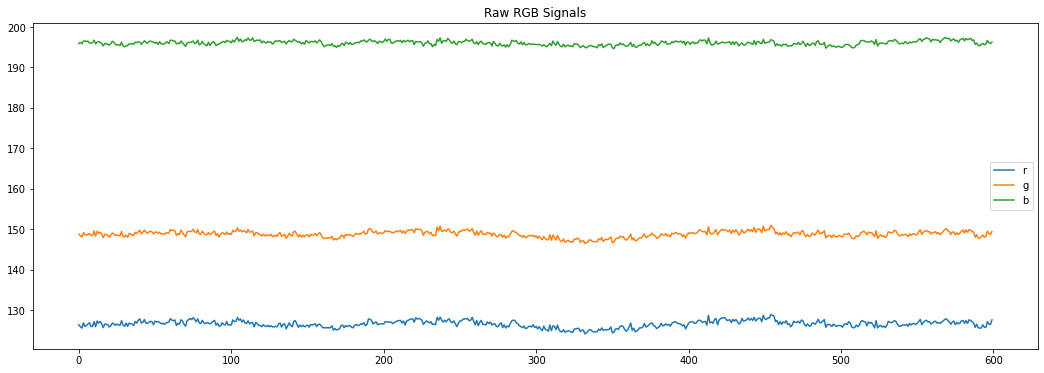

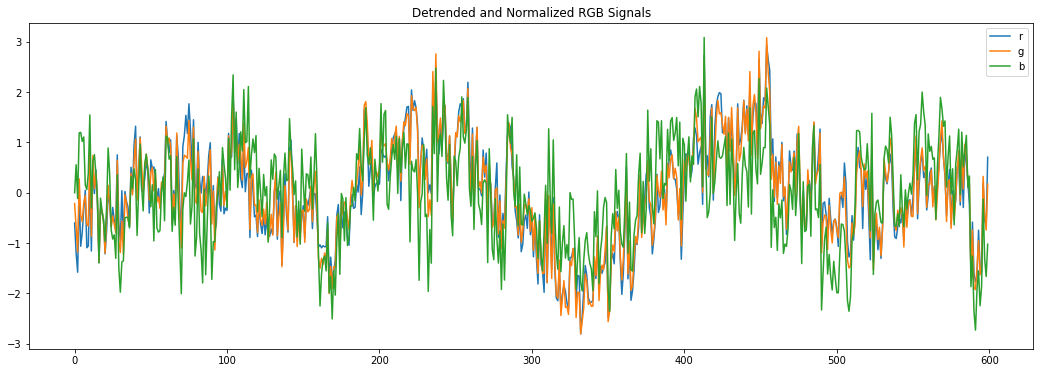

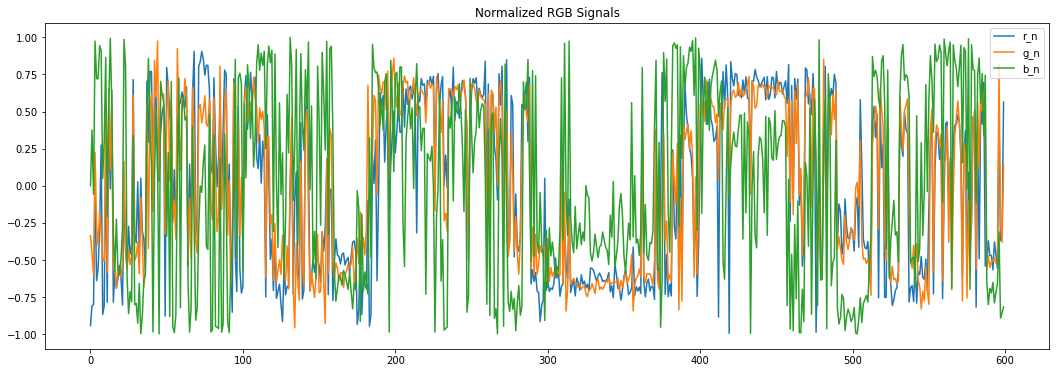

rPPG Signal 1 Length: 600


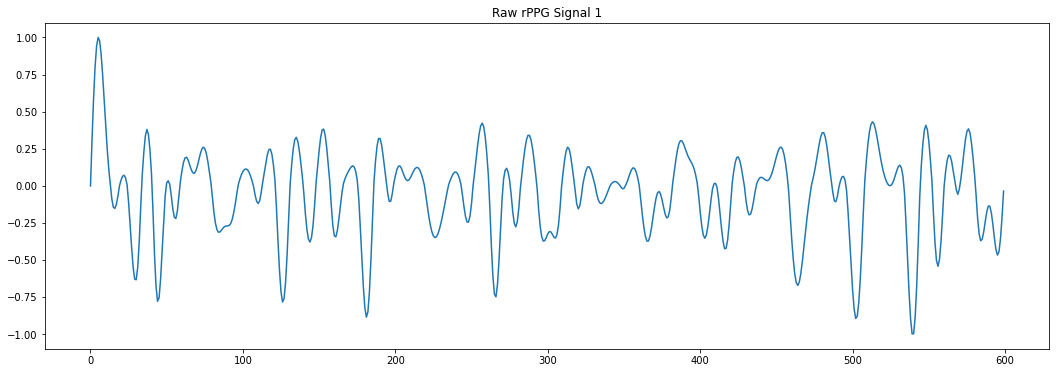

In [30]:
signal1 = chrominance(rgb1, plot = True)
signal1 = normalize_amplitude_to_1(signal1)
plt.plot(signal1)
plt.title('Raw rPPG Signal 1')

print('rPPG Signal 1 Length:', len(signal1))

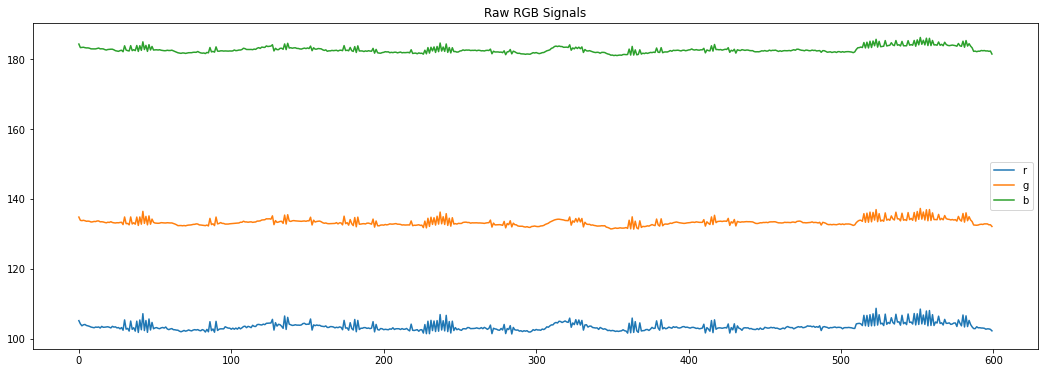

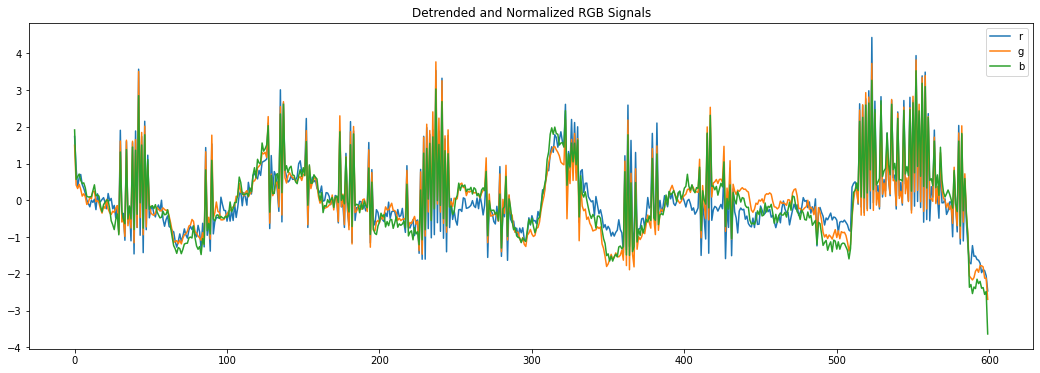

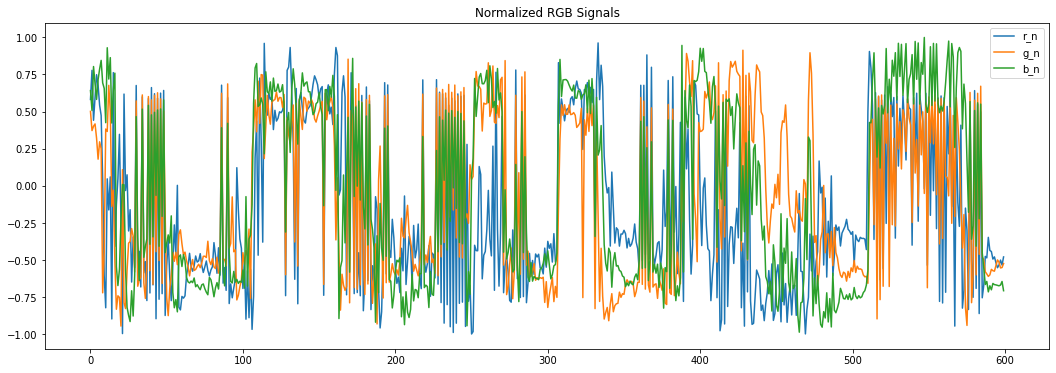

rPPG Signal 2 Length: 600


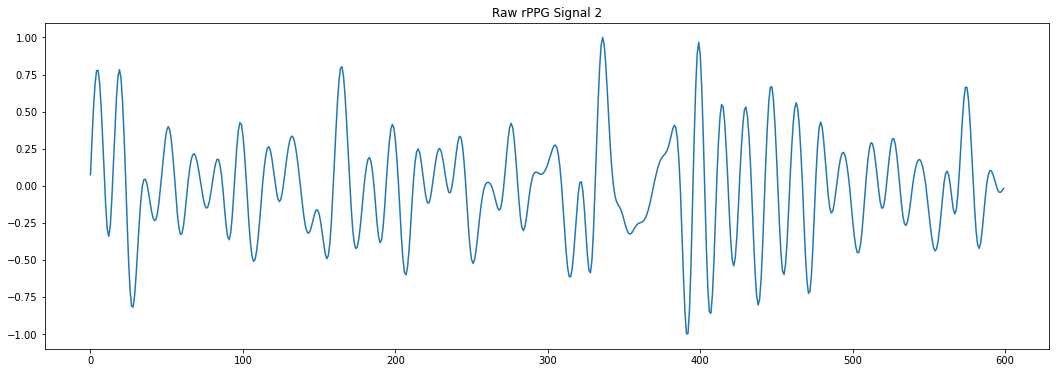

In [31]:
signal2 = chrominance(rgb2, plot = True)
signal2 = normalize_amplitude_to_1(signal2)
plt.plot(signal2)
plt.title('Raw rPPG Signal 2')

print('rPPG Signal 2 Length:', len(signal2))

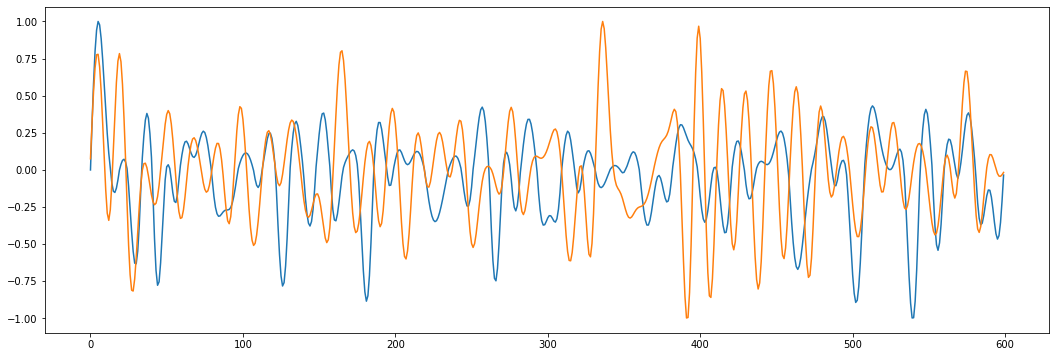

In [32]:
plt.plot(signal1)
plt.plot(signal2)
plt.show()